Cargamos las librerías, el conjunto de datos y algunas variables que emplearemos durante el proceso:

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pandas_profiling
%matplotlib inline

df = pd.read_csv('./processed_data/houses_integrated.csv')

# Definimos las opciones de visualizacion
pd.set_option('display.max_columns', 500)

# Definimos un listado de colores para visualizaciones
clr = {'pr': '#5F66A1', 'yw': '#f3ca75',
       'mg': '#c874b9', 'gn': '#599d70', 'br': '#636261'}
b = '\033[94m'  # para texto azul
o = '\033[93m'  # para texto naranja
n = '\033[0m'   # para texto normal

# Omitimos los warnings
warnings.filterwarnings('ignore')

# Verificación de los datos

En esta fase verificaremos la calidad de los datos por medio de una serie de procesos.

## Descarte de las casas de alquiler

En el conjunto de datos que disponemos, se mezclan anuncios con casa en venta y alquiler. Este análisis se centra en la venta de casas, por lo tanto, los anuncios ligados al alquiler han de descartarse.

No obstante, no hay ningún campo que permita esta división de forma directa. Por ello, se opta por emplear el precio para inferir si una casa está a la venta o en alquiler, ya que, en principio, han de tener precios muy distintos.

Analizemos por lo tanto los precios por medio de un histograma, acotando los precios entre 2.500€ y 20.000€,  a fin de encontrar un umbral a partir del cual poder considerar que una casa está en venta y no en alquiler:

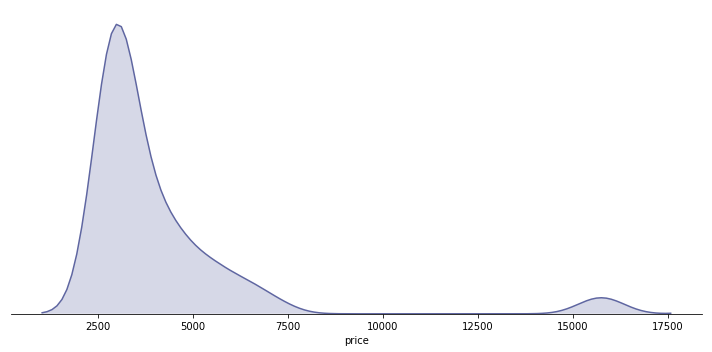

In [2]:
f, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
sns.despine(left=True)

(df['price']
 .pipe(sns.distplot, hist=False, color=clr['pr'], kde_kws={"shade": True, 'clip': (2500, 20000)}))

plt.setp(axes, yticks=[])
plt.tight_layout()

Vemos que hasta los 8.000€ hay casas, y que luego no hay viviendas hasta cerca de los 15.000€. Asumiremos que 15.000€ es más probable que sea el precio de venta a que sea el precio por un alquiler mensual, y viceversa, pensaremos que hasta los 8.000€ son casas de alquiler. Así, se opta por descartar todas las casas por debajo de los 12.500€:

In [3]:
h_num = df[df.price < 12500].shape[0]
df = df[df.price > 12500]
print(f'Se han descartado {h_num} casas de alquiler del dataset')

Se han descartado 2119 casas de alquiler del dataset


## Verificación de casas duplicadas

Puede que haya casas duplicadas en nuestro conjunto de datos. Cada anuncio de casa se define mediante un identificador único. Por ello, la forma más sencilla para verificar que no haya 2 anuncios repetidos es comprobando ese identificador:

In [4]:
h_num = df[df.house_id.duplicated()].shape[0]
df.drop_duplicates(subset='house_id', inplace=True)
print(f'Se han descartado {h_num} casas duplicadas del dataset')

Se han descartado 0 casas duplicadas del dataset


# Estandarización de variables

En este apartado se procede a estandarizar las variables, corrigiendo su tipo, y normalizando sus valores, (entendiendo por normalizar, asignarles el valor más representativo).

*NOTA: En este apartado no se tratarán ni los missing values ni los outliers. Su gestión se deja para más adelante.*

## Estudio de variables a estandarizar

Empezaremos analizando cómo han sido asignadas las variables:

In [5]:
df.dtypes

house_id               int64
ad_description        object
price                  int64
bath_num              object
condition             object
construct_date       float64
energetic_certif      object
floor                 object
ground_size          float64
heating               object
house_type            object
m2_real                int64
m2_useful            float64
orientation           object
room_num              object
air_conditioner        int64
balcony                int64
built_in_wardrobe      int64
chimney                int64
garage                object
garden                 int64
kitchen              float64
lift                 float64
reduced_mobility       int64
storage_room           int64
swimming_pool          int64
terrace                int64
unfurnished          float64
loc_zone              object
loc_district          object
loc_city              object
loc_neigh             object
pop_total              int64
pop_0-19               int64
pop_20-64     

De la lista superior, extraemos qué variables estudiaremos en la estandarización. En concreto, nos centraremos en 4 grupos: 
+ Por un lado estandarizaremos las variables numéricas que no hayan asignado como tal
+ Por otro lado, estudiaremos las variables categóricas
+ A continuación estudiaremos las variables categoricas binarias, es decir, booleanas
+ Finalmente, nos centraremos en las variables de texto ligadas a la ubicación

<br />

**VARIABLES NUMÉRICAS NO ASIGNADAS COMO TAL**

+ <font color=#5F66A1>*bath_num*<font>
+ <font color=#5F66A1>*room_num*<font>
+ <font color=#5F66A1>*garage*<font>


**VARIABLES CATEGÓRICAS**

+ <font color=#5F66A1>*condition*<font>
+ <font color=#5F66A1>*energetic_certif*<font>
+ <font color=#5F66A1>*floor*<font>
+ <font color=#5F66A1>*heating*<font>
+ <font color=#5F66A1>*house_type*<font>
+ <font color=#5F66A1>*orientation*<font>


**VARIABLES BOOLEANAS**

+ <font color=#5F66A1>*air_conditioner*<font>
+ <font color=#5F66A1>*balcony*<font>
+ <font color=#5F66A1>*built_in_wardrobe*<font>
+ <font color=#5F66A1>*chimney*<font>
+ <font color=#5F66A1>*garden*<font>
+ <font color=#5F66A1>*kitchen*<font>
+ <font color=#5F66A1>*lift*<font>
+ <font color=#5F66A1>*reduced_mobility*<font>
+ <font color=#5F66A1>*storage_room*<font>
+ <font color=#5F66A1>*swimming_pool*<font>
+ <font color=#5F66A1>*terrace*<font>
+ <font color=#5F66A1>*unfurnished*<font>


**VARIABLES DE TEXTO LIGADAS A LA UBICACIÓN**

+ <font color=#5F66A1>*loc_zone*<font>
+ <font color=#5F66A1>*loc_district*<font>
+ <font color=#5F66A1>*loc_city*<font>
+ <font color=#5F66A1>*loc_neigh*<font>

## Estandarización de variables numéricas

### <font color=#5F66A1>bath_num</font>

In [6]:
print(df.bath_num.unique())

['4' '2' '1' 'sin baños' '3' '5' '17' '6' '9' '7' '8' '11' '10' '15' '12']


Vemos como la ausencia de baños se identifica como 'sin baños', en forma de texto. Lo corregimos, y definimos la variable como numérica:

In [7]:
df['bath_num'] = (df['bath_num']
                  .str.replace('sin baños','0')
                  .astype('int64')
                 )

### <font color=#5F66A1>room_num</font>

In [8]:
print(df.room_num.unique())

['3' '4' '2' 'sin habitación' '5' '1' '8' '9' '6' '12' '10' '7' '11' '14'
 '17' '20' '34' '13']


Aquí tambien la ausencia de habitaciones se identifica en forma de texto, como 'sin habitación'. Lo corregimos, y definimos la variable como numérica:

In [9]:
df['room_num'] = (df['room_num']
                   .str.replace('sin habitación','0')
                   .astype('int64')
                  )

### <font color=#5F66A1>garage</font>

In [10]:
print(df.garage.unique()[:15])

['plaza de garaje incluida en el precio' nan
 'plaza de garaje por 9.500 eur adicionales'
 'plaza de garaje por 15.000 eur adicionales'
 'plaza de garaje por 50.000 eur adicionales'
 'plaza de garaje por 24.451 eur adicionales'
 'plaza de garaje por 24.452 eur adicionales'
 'plaza de garaje por 12.000 eur adicionales'
 'plaza de garaje por 33.000 eur adicionales'
 'plaza de garaje por 400.000 eur adicionales'
 'plaza de garaje por 34.000 eur adicionales'
 'plaza de garaje por 14.900 eur adicionales'
 'plaza de garaje por 25.000 eur adicionales'
 'plaza de garaje por 19.900 eur adicionales'
 'plaza de garaje por 35.000 eur adicionales']


Vemos que la variable refleja el precio de la plaza de garaje en forma de texto. Por lo tanto, extraemos el precio del texto y establecemos que la variable sea numérica:

In [11]:
df['garage'] = (df['garage']
                .str.replace('plaza de garaje incluida en el precio','0')
                .str.replace('.','')
                .str.extract('(\d{1,4})')
                .astype('float64')
               )

## Estandarización de variables categóricas

### <font color=#5F66A1>condition</font>

In [12]:
print(df.condition.unique())

['segunda mano/buen estado' 'segunda mano/para reformar' nan
 'promoción de obra nueva']


Vemos que hay 3 posibles categorías. Redefinimos los nombres de las categorías para mejorar su interpretabilidad.

In [13]:
df = df.replace({'condition':
                 {
                  'segunda mano/buen estado':'buen estado',
                  'segunda mano/para reformar':'para reformar',
                  'promoción de obra nueva':'obra nueva'
                 }})

df['condition'] = df['condition'].astype('category')

### <font color=#5F66A1>energetic_certif</font>

In [14]:
print(df.energetic_certif.unique())

['en trámite' 'no indicado' nan 'inmueble exento']


No requiere ningun tratamiento salvo definirla como categórica:

In [15]:
df['energetic_certif'] = df['energetic_certif'].astype('category')

### <font color=#5F66A1>floor</font>

In [16]:
print(df.floor.unique()[:15])

['3 plantas' 'planta 1ª exterior' '2 plantas' nan 'bajo exterior'
 'planta 3ª exterior' 'planta 5ª exterior' 'planta 2ª exterior' '1 planta'
 'planta 1ª' 'planta 4ª exterior' 'planta 2ª' 'planta 3ª' 'bajo'
 'planta 4ª']


Vemos que, a grandes rasgos, esta variable esconde lo que podrían ser 3 variables distintas:

+ Número de planta en la que se encuentra el domicilio
+ Indicador de si la planta está en el interior o en el exterior
+ Número de plantas de las que consta el domicilio

Por lo tanto, se procede a dividir la variable en 3. 

<br />

Empezamos generando la variable booleana <font color=#5F66A1>__indoor__</font>, que tomará el valor True si el domicilio está en el interior, y False en el caso contrario:

In [17]:
df['indoor'] = (df['floor']
                .str.contains('interior')
                .astype('category')   # no se define como bool porque aún contiene NaN
               )

print(df['indoor'].unique())

[False, NaN, True]
Categories (2, object): [False, True]


<br />

A continuación crearemos la variable <font color=#5F66A1>__floor_count__</font>, que recogerá el número de plantas de las que consta la casa.

Para ello, empezamos asignando como valor 1 a todas las casas que tengan información sobre la planta (las que estan como NaN las dejaremos por ahora tal cual, puesto que no tenemos información al respecto)

In [18]:
df['floor_count'] = np.nan
df['floor_count'][df.floor.notna()] = 1

A continuación, añadiremos la información sobre las casas con más de una planta. Para ello, seleccionaremos todas las celdas que contengan la palabra 'plantas' (en plural), y de allí extraeremos el número por medio de una expresión regular:

In [19]:
f_c = (df['floor'][df.floor.str.contains('plantas', na=False)]
       .str.extract('(\d+)')
       .astype('float64')
       .rename(columns={0:'floor_count'})
      )

Una vez hemos extraído el número de plantas de las casas con más de una, actualizamos la variable:

In [20]:
df.update(f_c)
print(df.floor_count.unique())

[ 3.  1.  2. nan  4.  5.]


<br />

Por último modificaremos la variable <font color=#5F66A1>__floor__</font>, para que solo recoja el número de planta en el que se encuentra el piso:

In [21]:
df['floor'] = (df['floor']
               .str.replace('exterior', '')
               .str.replace('interior', '')
               .str.replace('1 planta', '')
               .str.replace('(\d+) plantas', '')
               .str.strip()
               .str.replace('planta ', '')
               .str.replace('-1', '-1ª')
               .str.replace('-2', '-2ª')
               .replace('', np.nan)
               .astype('category')
              )

print(df.floor.unique())

[NaN, 1ª, bajo, 3ª, 5ª, ..., 21ª, 19ª, 30ª, 24ª, 17ª]
Length: 31
Categories (30, object): [1ª, bajo, 3ª, 5ª, ..., 19ª, 30ª, 24ª, 17ª]


### <font color=#5F66A1>heating</font>

In [22]:
print(df.heating.unique())

[nan 'calefacción individual: gas natural' 'calefacción individual'
 'no dispone de calefacción' 'calefacción central: gasoil'
 'calefacción individual: eléctrica'
 'calefacción individual: gas propano/butano' 'calefacción central'
 'calefacción central: gas' 'calefacción individual: gas'
 'calefacción individual: bomba de frío/calor'
 'calefacción central: gas propano/butano'
 'calefacción central: gas natural' 'calefacción individual: gasoil']


Sustraemos la palabra 'calefacción' para mayor interpretabilidad, y la definimos como categórica:

In [23]:
df['heating'] = (df['heating']
                 .str.replace('calefacción ', '')
                 .astype('category')
                )

### <font color=#5F66A1>house_type</font>

In [24]:
print(df.house_type.unique())

[' Casa o chalet independiente' 'Piso' ' Casa de pueblo' ' Casa rural'
 'Dúplex' ' Chalet adosado' ' Caserón' ' Casa o chalet' ' Finca rústica'
 'Casa rural' 'Ático' 'Estudio' ' Chalet pareado' ' Palacio'
 ' Casa terrera' ' Torre' ' Castillo' ' Cortijo']


Eliminamos los espacios en blanco y la definimos como categórica:

In [25]:
df['house_type'] = (df['house_type']
                    .str.strip()
                    .astype('category')
                   )

### <font color=#5F66A1>orientation</font>

In [26]:
print(df.orientation.unique())

[nan 'sur' 'sur, este, oeste' 'este, oeste' 'norte' 'norte, sur, este'
 'este' 'sur, este' 'sur, oeste' 'norte, este, oeste' 'norte, sur'
 'norte, sur, este, oeste' 'norte, este' 'norte, sur, oeste' 'oeste'
 'norte, oeste']


No requiere estandarización salvo definirla como categórica:

In [27]:
df['orientation'] = (df['orientation'].astype('category'))

## Estandarización de variables booleanas

Analizamos qué valores tienen las variables booleanas:

In [28]:
print(f'Valores para {b}air_conditioner{n}: {df.air_conditioner.unique()}')
print(f'Valores para {b}balcony{n}: {df.balcony.unique()}')
print(f'Valores para {b}built_in_wardrobe{n}: {df.built_in_wardrobe.unique()}')
print(f'Valores para {b}chimney{n}: {df.chimney.unique()}')
print(f'Valores para {b}garden{n}: {df.garden.unique()}')
print(f'Valores para {b}kitchen{n}: {df.kitchen.unique()}')
print(f'Valores para {b}lift{n}: {df.lift.unique()}')
print(f'Valores para {b}reduced_mobility{n}: {df.reduced_mobility.unique()}')
print(f'Valores para {b}storage_room{n}: {df.storage_room.unique()}')
print(f'Valores para {b}swimming_pool{n}: {df.swimming_pool.unique()}')
print(f'Valores para {b}terrace{n}: {df.terrace.unique()}')
print(f'Valores para {b}unfurnished{n}: {df.unfurnished.unique()}')

Valores para air_conditioner: [0 1]
Valores para balcony: [1 0]
Valores para built_in_wardrobe: [1 0]
Valores para chimney: [0 1]
Valores para garden: [1 0]
Valores para kitchen: [nan]
Valores para lift: [nan  0.  1.]
Valores para reduced_mobility: [0 1]
Valores para storage_room: [1 0]
Valores para swimming_pool: [1 0]
Valores para terrace: [0 1]
Valores para unfurnished: [nan]


Por un lado  vemosque las variables <font color=#5F66A1>__kitchen__</font> y <font color=#5F66A1>__unfurnished__</font> solo contienen *NaN*, probablemente porque se traten de variables ligadas exclusivamente a casas de alquiler. Por lo tanto, las eliminamos:

In [29]:
df = df.drop(columns=['kitchen', 'unfurnished'])

Por otra parte, vemos que la variable <font color=#5F66A1>__lift__</font>, a pesar de ser booleana, contiene valores NaN, por lo que la definimos como categórica por ahora:

In [30]:
df['lift'] = df['lift'].astype('category')

Finalmente, el resto de variables categóricas las definimos como booleanas:

In [31]:
df['air_conditioner'] = df['air_conditioner'].astype('bool')
df['balcony'] = df['balcony'].astype('bool')
df['built_in_wardrobe'] = df['built_in_wardrobe'].astype('bool')
df['chimney'] = df['chimney'].astype('bool')
df['garden'] = df['garden'].astype('bool')
df['reduced_mobility'] = df['reduced_mobility'].astype('bool')
df['storage_room'] = df['storage_room'].astype('bool')
df['swimming_pool'] = df['swimming_pool'].astype('bool')
df['terrace'] = df['terrace'].astype('bool')

In [32]:
print(f'Nuevos valores para {b}air_conditioner{n}: {df.air_conditioner.unique()}')
print(f'Nuevos valores para {b}balcony{n}: {df.balcony.unique()}')
print(f'Nuevos valores para {b}built_in_wardrobe{n}: {df.built_in_wardrobe.unique()}')
print(f'Nuevos valores para {b}chimney{n}: {df.chimney.unique()}')
print(f'Nuevos valores para {b}garden{n}: {df.garden.unique()}')
print(f'Nuevos valores para {b}lift{n}: {df.lift.unique()}')
print(f'Nuevos valores para {b}reduced_mobility{n}: {df.reduced_mobility.unique()}')
print(f'Nuevos valores para {b}storage_room{n}: {df.storage_room.unique()}')
print(f'Nuevos valores para {b}swimming_pool{n}: {df.swimming_pool.unique()}')
print(f'Nuevos valores para {b}terrace{n}: {df.terrace.unique()}')

Nuevos valores para air_conditioner: [False  True]
Nuevos valores para balcony: [ True False]
Nuevos valores para built_in_wardrobe: [ True False]
Nuevos valores para chimney: [False  True]
Nuevos valores para garden: [ True False]
Nuevos valores para lift: [NaN, 0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
Nuevos valores para reduced_mobility: [False  True]
Nuevos valores para storage_room: [ True False]
Nuevos valores para swimming_pool: [ True False]
Nuevos valores para terrace: [False  True]


## Estandarización de variables ligadas a la ubicación

La localización de cada vivienda viene especificada por medio de 4 variables distintas, las cuales están organizadas de forma jerárquica del siguiente modo:

+ <font color=#5F66A1>__loc_zone__</font> &nbsp; > &nbsp;<font color=#5F66A1>__loc_city__</font> &nbsp;> &nbsp;<font color=#5F66A1>__loc_district__</font> &nbsp;> &nbsp;<font color=#5F66A1>__loc_neigh__</font>

### <font color=#5F66A1>loc_zone</font>

In [33]:
print(df.loc_zone.unique())

['Encartaciones, Vizcaya' 'Lea-Artibai, Vizcaya' 'Duranguesado, Vizcaya'
 'Gran Bilbao, Vizcaya' 'Busturialdea, Vizcaya' 'Arratia-Nervión, Vizcaya'
 'Tolosaldea, Guipúzcoa' 'Donostialdea, Guipúzcoa' 'Uribe-Butroe, Vizcaya'
 'Alto Deba, Guipúzcoa' 'Bajo Bidasoa, Guipúzcoa' 'Bajo Deba, Guipúzcoa'
 'Goierri, Guipúzcoa' 'Urola Kosta, Guipúzcoa']


Definimos las provincias con las iniciales y convertimos la variable en categórica:

In [34]:
df['loc_zone'] = (df['loc_zone']
                  .str.replace(', Vizcaya',' (BIZ)')
                  .str.replace(', Guipúzcoa',' (GIP)')
                  .astype('category')
                 )

print(df.loc_zone.unique())

[Encartaciones (BIZ), Lea-Artibai (BIZ), Duranguesado (BIZ), Gran Bilbao (BIZ), Busturialdea (BIZ), ..., Alto Deba (GIP), Bajo Bidasoa (GIP), Bajo Deba (GIP), Goierri (GIP), Urola Kosta (GIP)]
Length: 14
Categories (14, object): [Encartaciones (BIZ), Lea-Artibai (BIZ), Duranguesado (BIZ), Gran Bilbao (BIZ), ..., Bajo Bidasoa (GIP), Bajo Deba (GIP), Goierri (GIP), Urola Kosta (GIP)]


### <font color=#5F66A1>loc_city</font>

In [35]:
print(df.loc_city.unique()[:15])

['Gordexola' 'Karrantza Harana/Valle de Carranza' 'Balmaseda' 'Güeñes'
 'Zalla' 'Artzentales' 'Sopuerta' 'Galdames' 'Trucios-Turtzioz'
 'Lanestosa' 'Mendexa' 'Lekeitio' 'Berriatua' 'Ondarroa' 'Amoroto']


Los valores están ya lo suficientemente estandarizados, por lo que los dejamos como están, y establecemos la variable como categórica:

In [36]:
df['loc_city'] = df['loc_city'].astype('category')

### <font color=#5F66A1>loc_district</font>

In [37]:
print(f"Número de distritos: {len(df.loc_district.unique())}")

Número de distritos: 5604


Vemos que hay {{len(df.loc_district.unique())}} distritos distintos. No obstante, en muchos casos, en vez del distrito como tal, el campo guarda información relativa a la calle, urbanización, etc., como puede verse a continuación:

In [38]:
print(df.sample(frac=1, random_state=89)['loc_district'][df.loc_district.notnull()].head(5))

6549             Distrito Lasesarre
1679                       san juan
10168    Distrito Begoña - Santutxu
23584                 Urb. ERREZUBI
5071            Distrito Las Arenas
Name: loc_district, dtype: object


Dado que cada distrito está precedido por la palabra 'Distrito', eliminamos todos los valores que no coincidan con este patrón:

In [39]:
df['loc_district'] = (df['loc_district']
                      .str.extract(r'(Distrito .*)')[0]
                      .str.replace('Distrito ','')
                     )

Por otro lado, para asegurarnos de que no haya distritos distintos compartiendo un mismo nombre, agregaremos las iniciales de cada ciudad:

In [40]:
df['loc_district'] = (np.where(df.loc_district.notnull()
                      , df.loc_district+' ('+df.loc_city.str[:4]+')'
                      , np.nan)
                     )

print(df.sample(frac=1, random_state=89)['loc_district'][df.loc_district.notnull()].head(5))

6549                                   Lasesarre (Bara)
10168                          Begoña - Santutxu (Bilb)
5071                                  Las Arenas (Getx)
4582                                      Neguri (Getx)
24214    Lapice - Larreaundi - Olaberria - Meaka (Irun)
Name: loc_district, dtype: object


Finalmente, comprobamos el número de distritos que hay tras el proceso de limpieza:

In [41]:
print(f"Número de distritos tras limpieza: {len(df.loc_district.unique())}")

Número de distritos tras limpieza: 80


### <font color=#5F66A1>loc_neigh</font>

In [42]:
print(f"Número de barrios: {len(df.loc_neigh.unique())}")

Número de barrios: 3400


Vemos que hay {{len(df.loc_neigh.unique())}} barrios distintos. Sin embargo, sucede lo mismo que sucedía con el distrito, que en vez del barrio, en muchos casos el campo guarda información relativa a la calle, urbanización, etc.:

In [43]:
print(df.sample(frac=1, random_state=89)['loc_neigh'][df.loc_neigh.notnull()].head(5))

10168    Barrio Santutxu-Basarrate
23584           Calle DONOSTIA, 34
5071                   Barrio Romo
4582                      Etxezuri
21988        Barrio Área Romántica
Name: loc_neigh, dtype: object


En este caso, el barrio viene precedido siempre por la palabra 'Barrio'. Así, repetimos el mismo proceso que en el anterior caso:

In [44]:
df['loc_neigh'] = (df['loc_neigh']
                      .str.extract(r'(Barrio .*)')[0]
                      .str.replace('Barrio ','')
                     )

df['loc_neigh'] = (np.where(df.loc_neigh.notnull()
                      , df.loc_neigh+' ('+df.loc_city.str[:4]+')'
                      , np.nan)
                  )

print(df.sample(frac=1, random_state=89)['loc_neigh'][df.loc_neigh.notnull()].head(5))

10168    Santutxu-Basarrate (Bilb)
5071                   Romo (Getx)
21988        Área Romántica (Dono)
17084        Rekalde Centro (Bilb)
5643               Usategui (Getx)
Name: loc_neigh, dtype: object


Finalmente, comprobamos el número de barrios que hay tras el proceso de limpieza:

In [45]:
print(f"Número de barrios tras limpieza: {len(df.loc_neigh.unique())}")

Número de barrios tras limpieza: 79


# Gestión de ruido y valores extremos

En este apartado cotejaremos que los valores estén dentro de un rango plausible. De este modo, por cada variable numérica, gestionaremos tanto los valores extremos como las incongruencias. Además, se cotejará también la veracidad de algunas variables categóricas. 

## Ruido y outliers en variables numéricas

### <font color=#5F66A1>m2_real</font> & <font color=#5F66A1>m2_useful</font>

Empezemos mostrando en un boxplot la dispersión de los metros cuadadros reales de las viviendas:

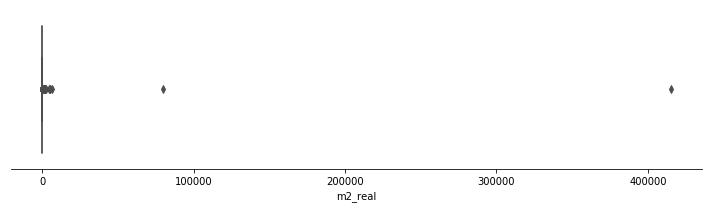

In [46]:
f, axes = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.despine(left=True)

(df
 .loc[:,'m2_real']
 .dropna()
 .pipe(sns.boxplot, color=clr['pr'], boxprops=dict(alpha=.7)))

plt.setp(axes, yticks=[])
plt.tight_layout()

Observamos que hay 2 casos muy extremos. Los exploramos a fin de determinar cómo tratarlos:

In [47]:
df.query('m2_real > 50000').style.set_properties(subset=['ad_description'], **{'min-width': '400px'})

,house_id,ad_description,price,bath_num,condition,construct_date,energetic_certif,floor,ground_size,heating,house_type,m2_real,m2_useful,orientation,room_num,air_conditioner,balcony,built_in_wardrobe,chimney,garage,garden,lift,reduced_mobility,storage_room,swimming_pool,terrace,loc_zone,loc_district,loc_city,loc_neigh,pop_total,pop_0-19,pop_20-64,pop_>=65,pop_foreign,rent,indoor,floor_count
15587,82667064,"Se vende magnífica casa individual de tres plantas en la zona de Unbemendi, Laukiz. La casa dispone de 2.037 metros cuadrados de terreno y 415 metros cuadrados de vivienda incluyendo el txoko. Consta de ocho habitaciones amplias, dos salones comedor muy amplios y luminosos, siete baños, una cocina comedor, tres terrazas y un garaje con capacidad para tres o cuatro coches. Dispone de tres chimeneas, un txoko de 300m2 y un trastero.,Para más información no dudes en ponerte en contacto con nosotros.",720000,6,para reformar,nan,en trámite,nan,2037,nan,Casa o chalet independiente,415000,nan,"norte, sur, este, oeste",8,False,False,True,False,0,True,nan,True,True,True,True,Uribe-Butroe (BIZ),nan,Laukiz,nan,1191,24,57,19,6.5,31275,False,3
18436,39173329,"Vendemos un bonito y típico caserío vasco de 300 metros cuadrados de superficie situado en un entorno idílico en pleno corazón de Gipuzkoa, y 80.000 metros cuadrados de terreno. El caserío tiene tres plantas y dispone de 4 habitaciones, amplio salón comedor, cocina, baño. Amueblado. También dispone de garaje amplio y trastero. Tiene unas excelentes vistas y está muy bien comunicado.",425000,1,para reformar,nan,nan,nan,80000,nan,Casa rural,80000,nan,nan,4,False,False,False,False,0,True,nan,False,True,False,True,Tolosaldea (GIP),nan,Baliarrain,nan,137,31,56,13,6.7,21982,False,3


En la descripción del anuncio se ve que en un caso han sumado 3 ceros de más a la superficie real, y en el otro, han asignado el valor de la párcela. Por lo tanto, dado que en la descripción se detalla el tamaño real, se corrigen manualmente, y se vuelve a representar el boxplot:

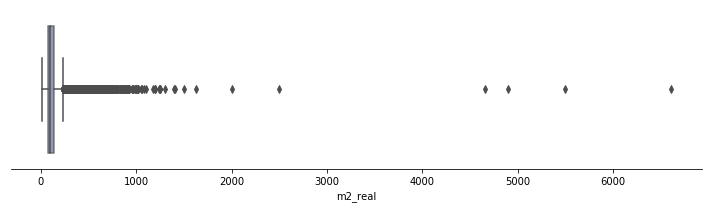

In [48]:
df['m2_real'][df.house_id == 82667064] = 415
df['m2_real'][df.house_id == 39173329] = 300

f, axes = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.despine(left=True)

(df
 .loc[:,'m2_real']
 .dropna()
 .pipe(sns.boxplot, color=clr['pr'], boxprops=dict(alpha=.7)))

plt.setp(axes, yticks=[])
plt.tight_layout()

Pese a haber resuelto los casos más extremos, vemos que aún siguen existiendo valores muy alejados del resto. De modo que volvemos a analizarlos a fin de determinar qué tratamiento darles:

In [49]:
out_m2 = len(df[df['m2_real'] >1500])
(df
 .query('m2_real > 1500')
 .sort_values('m2_real',ascending=False)
 .style.set_properties(subset=['ad_description'], **{'min-width': '1000px'})
)

,house_id,ad_description,price,bath_num,condition,construct_date,energetic_certif,floor,ground_size,heating,house_type,m2_real,m2_useful,orientation,room_num,air_conditioner,balcony,built_in_wardrobe,chimney,garage,garden,lift,reduced_mobility,storage_room,swimming_pool,terrace,loc_zone,loc_district,loc_city,loc_neigh,pop_total,pop_0-19,pop_20-64,pop_>=65,pop_foreign,rent,indoor,floor_count
20725,82012713,"Obra nueva en lezo ático duplex, cocina equipada, salón, 3 habitaciones y 2 baños. Dispone de gran balcón corrido y lavadero-tendedero más 3 balcones. Todo exterior. Garaje opcional en el mismo edificio. Sin comisión de inmobiliaria.",280000,2,nan,2018,no indicado,4ª,nan,individual: gas natural,Dúplex,6605,87,"este, oeste",3,False,True,False,False,nan,False,1,True,False,False,True,Donostialdea (GIP),nan,Lezo,nan,6045,19,64,17,5.6,18427,False,1
12437,39987420,"CONVENTO de SANTA CLARA (CLARISAS) DESDE EL AÑO 1469 SITUADO EN ORDUÑA.,Tiene 5.500 m2 distribuidos en 3 plantas.,-En la planta baja se encuentra la iglesia, el claustro, la sacristía, la cocina, comedores, etc.,-En la primera planta se encuentran las habitaciones, locutorios, salas de labor, botica, biblioteca, etc. ,-La planta bajo cubierta se encuentra diáfana.,Tiene 24.000 metros de terreno. Este convento tenia anexo una hermosa huera de unas dos hectáreas, rodeada toda ella de una gruesa tapia de unos 3 mts. de altura. En dicha zona existen 2-3 manantiales de agua potable cuyo caudal es muy abundante. ,Imprescindible verlo. Consúltenos.",2400000,7,nan,nan,no indicado,nan,nan,individual: gas propano/butano,Casa o chalet independiente,5500,nan,nan,10,False,False,False,False,nan,False,nan,False,False,False,False,Arratia-Nervión (BIZ),nan,Urduña/Orduña,nan,4180,20,59,21,8.2,18107,nan,nan
7385,85178086,"Erandio junto al Makro, Nave industrial a la venta, situada en el municipio de Erandio (Bizkaia), concreta mente en Asua, la entrada al corredor del Txorierri. con acceso directo al Puente de Rontegui y la A-8. Superficie total: 4.900 m2. Altura máxima: 4,30 m. Sobrecarga entreplanta: 1.500 Kg/m2. Excelente localización y ubicación estratégica. Buena construcción y reformas importantes recientes en los edificios.",3000000,2,nan,nan,no indicado,nan,nan,nan,Piso,4900,nan,nan,3,False,False,False,False,nan,False,nan,False,False,False,False,Gran Bilbao (BIZ),nan,Erandio,nan,24222,18,61,21,9.8,16001,nan,nan
6854,39733981,"! EXCELENTE OPORTUNIDAD!, , Si quieres vivir en un piso reformado, cerca de colegios, parada de bus a 50 metros y a 5 minutos del Hospital de Cruces, esta es tú casa., , Nos encontramos con una vivienda semi exterior que consta de dos habitaciones, salón, un baño y cocina. La calefacción y el agua caliente son eléctricas de bajo consumo, tiene una iluminación increíble principalmente en el salón y la cocina. Todos los armarios de la vivienda son empotrados, el suelo, ventanas y puertas recién reformados. En un edificio de hormigón., , ¡PARA ENTRAR A VIVIR!, ,Visita nuestra página Web:.",150000,1,buen estado,nan,en trámite,2ª,nan,nan,Piso,4653,46,"sur, este",2,False,False,False,False,nan,False,0,False,False,False,False,Gran Bilbao (BIZ),Cruces (Bara),Barakaldo,nan,100435,17,60,23,9,16935,False,1
19740,81926009,"Se vende edificio destinado antiguamente a camping en Itziar Deba. Se sitúa al lado de la carretera general que une Deba e Itziar.,El edificio ocupa una superficie construida de 618,61 metros cuadrados.,Consta de planta semisótano, planta baja, planta primera y planta bajo cubierta.,Interesante para diversos usos, residencia de la tercera edad, apartamentos turísticos...",800000,1,para reformar,nan,en trámite,nan,10000,nan,Finca rústica,2500,2000,nan,1,False,False,False,False,nan,True,nan,False,False,False,False,Bajo Deba (GIP),nan,Deba,nan,5457,19,59,22,7.8,22065,nan,nan
12378,37071101,"HOSTELERIA GRAN FINCA Y Palacio 1250m. mas casa de 400 a 600m. mas capilla anexa a palacio a 15 minutos de Bilbao y 20 de Vitoria,grandes peticiones de eventos y bodas 

Observamos que hay {{out_m2}} viviendas con precios superiores a los 1.500 $m^2$ reales, entre las cuales hay un convento, un camping, una nave industrial... este tipo de edificios quedan fuera de nuestro objeto de estudio y podrían generar distorsión, por lo que se eliminan. Por otro lado, encontramos nuevamente viviendas que tienen mal definida su superficie; éstas las corregimos de forma manual mediante la información contenida en otros campos:

In [50]:
df['m2_real'][df.house_id == 82012713] = 90
df['m2_real'][df.house_id == 39733981] = 46

h_num = len(df[df.m2_real > 1500])
df = df[df.m2_real < 1500]
print(f'Se han descartado {h_num} viviendas')

Se han descartado 5 viviendas


Por otro lado, en el otro extremo, exploramos si hay viviendas con valores de superficie nulos o negativos: 

In [51]:
cnt = len(df.query('m2_real < 1'))
print(f"Hay {cnt} viviendas con superficies nulas o negativas")

Hay 0 viviendas con superficies nulas o negativas


Una vez hemos gestionado los valores extremos de la variable <font color=#5F66A1>__m2_real__</font>, hacemos lo propio con <font color=#5F66A1>__m2_useful__</font>:

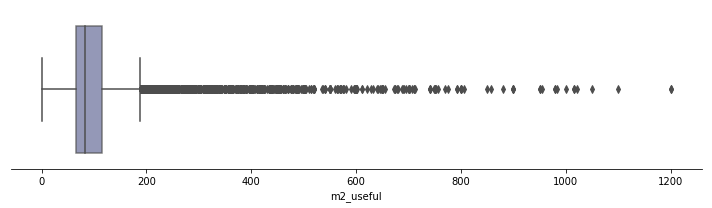

In [52]:
f, axes = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.despine(left=True)

(df
 .loc[:,'m2_useful']
 .dropna()
 .pipe(sns.boxplot, color=clr['pr'], boxprops=dict(alpha=.7)))

plt.setp(axes, yticks=[])
plt.tight_layout()

Vemos que el valor más extremo se encuentra en los 1.200 $m^2$, lo cual entra dentro del rango plausible tras haber eliminado las casas con más de 1.500 $m^2$ reales, por lo que en este caso, no se realiza ninguna acción más, y se procede a verificar que no haya valores nulos o negativos:

In [53]:
cnt = len(df.query('m2_useful < 1'))
print(f"Hay {cnt} viviendas con superficies nulas o negativas")

Hay 0 viviendas con superficies nulas o negativas


Por último, los metros útiles de una vivienda han de ser inferiores a sus metros reales. Verificamos si hay algún caso que no cumpla este criterio:

In [54]:
cnt = len(df.query('m2_real < m2_useful'))
print(f"Hay {cnt} viviendas con incongruencias entre las superficies")

Hay 0 viviendas con incongruencias entre las superficies


Además, por lo general, los metros útiles se situan en torno a un 0%-20% por debajo de los metros reales. Por ello, exploremos gráficamente esta relación para hallar valores extremos:

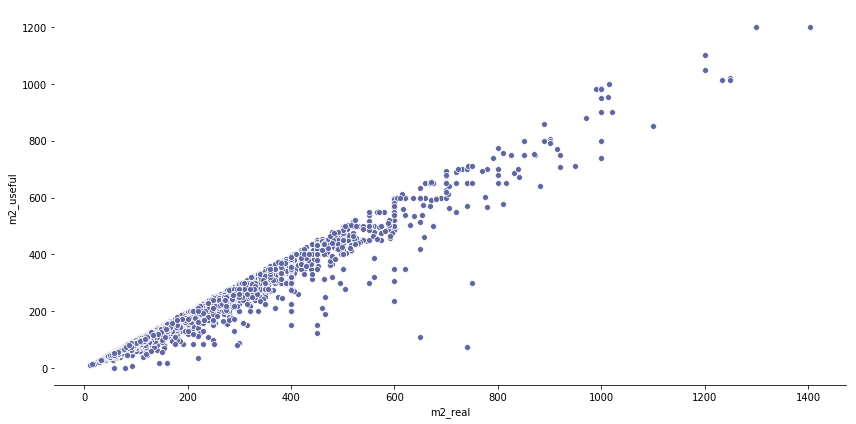

In [55]:
f, axes = plt.subplots(1, 1, figsize=(12, 6), sharex=True)
sns.despine(left=True)

(df.pipe((sns.scatterplot, 'data'),x="m2_real", y="m2_useful", color=clr['pr'], legend="full"))

plt.tight_layout()

# añadir 2 rectas... una en y=x (0%), la otra en y=x/0.8 (20%)

Comprobamos que, en efecto, la mayoría de viviendas disponen la relación esperada. No obstante, también encontramos viviendas con muy pocos metros útiles para los metros reales que tienen. Para cotejar si son plausibles, exploremos las 5 viviendas con mayor diferencia entre ambas superficies:

In [56]:
df_out = df
df_out['m2_relation'] = df['m2_real'] - df['m2_useful']

(df_out
    .sort_values('m2_relation', ascending=False)[:5]
    .style.set_properties(subset=['ad_description'], **{'min-width': '1400px'})
)

,house_id,ad_description,price,bath_num,condition,construct_date,energetic_certif,floor,ground_size,heating,house_type,m2_real,m2_useful,orientation,room_num,air_conditioner,balcony,built_in_wardrobe,chimney,garage,garden,lift,reduced_mobility,storage_room,swimming_pool,terrace,loc_zone,loc_district,loc_city,loc_neigh,pop_total,pop_0-19,pop_20-64,pop_>=65,pop_foreign,rent,indoor,floor_count,m2_relation
20097,85089573,"Ideal para los que buscan la máxima comodidad., , Apartamento de dos habitaciones en edificio de 15 años y ubicación inmejorable: junto a la Plaza Grande y Leku-Eder., , La vivienda está aprovechada al máximo. El hall ubicado en el centro de la vivienda, separa, por un lado, las zonas comunes (cocina y salón) que se conectan en un espacio diáfano con vistas a Aita Agirre Plaza, que tiene orientación sur por lo que entra mucha luminosidad. Al otro lado del hall, encontramos el baño completo con bañera y las dos habitaciones que dan a San Bartolomé, una de ellas con balcón. , , Características:, - Edificio de hormigón, - Tanto las ventanas como las puertas son de madera barnizada y las ventanas tienen además doble acristalamiento. , - Caldera individual de gas natural y radiadores de aluminio en todas las estancias., - Acceso desde Aita Agirre Plaza, sin barreras arquitectónicas., , , ,CEE en trámite.",188000,1,buen estado,nan,en trámite,2ª,nan,nan,Piso,740,74,nan,2,False,False,False,False,nan,False,1,False,False,False,True,Bajo Deba (GIP),nan,Elgoibar,nan,11582,20,58,22,10.2,21714,False,1,666
17787,84234935,"CASA EN UNA PLANTA EN PARCELA DE 650 m2, de reciente construcción en la zona de andara mari. Consta de salón-comedor, cocina americana y salida a amplio porche, 3 habitaciones y 2 baños ( 1 incorporado en la habitación principal)., , Posibilidad de ampliar la vivienda., , En perfecto estado., ,Plentzia es un municipio de Bizkaia, ubicado en la margen derecha del último meandro de su ría, justo antes de su desembocadura en la bahía de Plencia. Se encuentra a unos 25 kilómetros al norte de Bilbao. Plentzia está muy bien comunicado ya que es la última parada de la estación Línea 1 del Metro Bilbao, por carretera el acceso se realiza por la carretera BI-2122 desde Sopelana o la BI-2120 desde Mungia y también la línea A3451 de Bizkaibus que tiene el recorrido: Las Arenas/Areeta - Armintza.",455000,2,buen estado,nan,en trámite,nan,nan,nan,Casa o chalet,650,110,nan,3,False,False,False,False,nan,False,nan,False,False,False,False,Uribe-Butroe (BIZ),nan,Plentzia,nan,4363,20,63,17,9.3,22374,nan,nan,540
21220,39289460,"Iparralde Inmobiliaria presenta: Sobre parcela de 15.767 m2 Exclusiva Mansion de 300 m2 +450 m2 en San Sebastián (Igeldo) con sublimes vistas al mar desde toda la casa. La entrada principal se encuentra flanqueada por un precioso estanque de agua de manantial y nos da acceso a la planta principal donde nos encontramos un grandioso salón comedor de 50 m2 con la vista panorámica del Mar Cantabrico y con acceso a una gran terraza de 40 m2 a la cual se accede también desde una alegre cocina perfectamente equipada con todas las comodidades. Encontramos también en esta planta principal 3 hermosas habitaciones con acceso a jardín y que disfrutan de maravillosas vistas. 2 baños completos con bañera dan servicio a esta planta. En la planta alta dispondremos de otras 3 habitaciones dobles todas ellas con vistas preciosas. Mención especial merece la suite principal con unas increíbles vistas al Mar, vestidor y baño incorporado. 2 baños más dan servicio a esta planta. Todas las estancias de las casa son exteriores, incluso los baños. En la planta sótano, de una superficie de 450 m2 disponemos de la zona de garaje con puerta motorizada para varios vehículos y de una Singular zona de Piscina cubierta con acceso directo al Jardín y compuesta por: Zona de baño, vestuarios, 3 duchas y 2 baños, cocina de verano y zona de esparcimiento. Esta casa destaca sobre las demás de la zona por ser la única que dispone de un 100% de Pr

Salvo el caso más extremo, a la cual se le ha asigando un 0 de menos, el resto de viviendas no presentan anomalías aparentes. Por lo tanto, se modifica el valor más extremo, y se asume que el resto entran dentro de un rango plausible:

In [57]:
df['m2_useful'][df.house_id == 85089573] = 740

### <font color=#5F66A1>price</font>

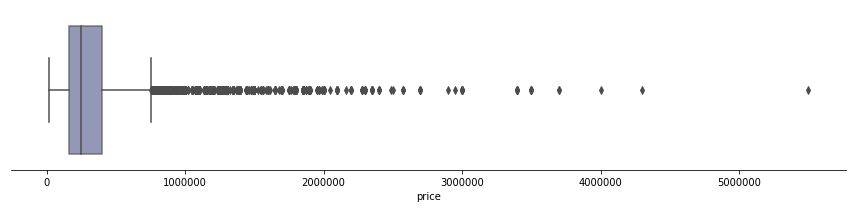

In [58]:
f, axes = plt.subplots(1, 1, figsize=(12, 3), sharex=True)
sns.despine(left=True)

(df
 .loc[:,'price']
 .pipe(sns.boxplot, color=clr['pr'], boxprops=dict(alpha=.7)))

plt.setp(axes, yticks=[])
plt.tight_layout()

Vemos que los datos tienen una distribución asimétrica positiva, con una larga cola que se extiende hacia la derecha.

Los valores más extremos corresponden a casas que cuestan entre 3 y 4 millones, las cuales son plausibles, por lo que se opta por mantenerlos.

### <font color=#5F66A1>construct date</font>

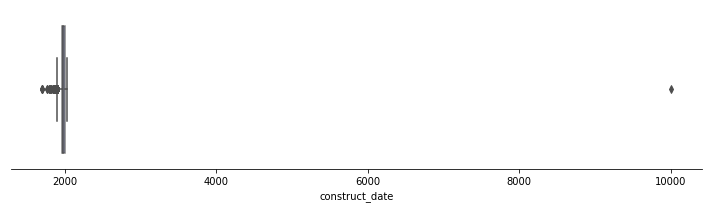

In [59]:
f, axes = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.despine(left=True)

(df
 .loc[:,'construct_date']
 .dropna()
 .pipe(sns.boxplot, color=clr['pr'], boxprops=dict(alpha=.7)))

plt.setp(axes, yticks=[])
plt.tight_layout()

Vemos que hay ...

In [60]:
del_count = len(df.query('construct_date > 2030'))
df['construct_date'] = (np.where(df.construct_date > 2030
                      , np.nan
                      , df.construct_date)
                        )
print(f"Se han modificado {del_count} valores")

Se han modificado 1 valores


### <font color=#5F66A1>garage</font>

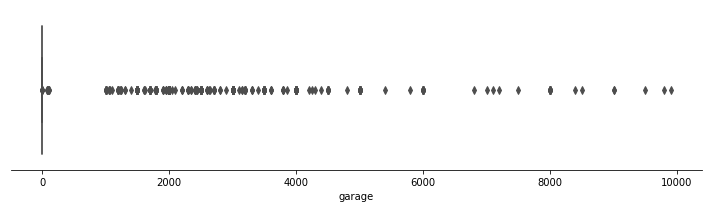

In [61]:
f, axes = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.despine(left=True)

(df
 .loc[:,'garage']
 .dropna()
 .pipe(sns.boxplot, color=clr['pr'], boxprops=dict(alpha=.7)))

plt.setp(axes, yticks=[])
plt.tight_layout()

### <font color=#5F66A1>room_num</font>

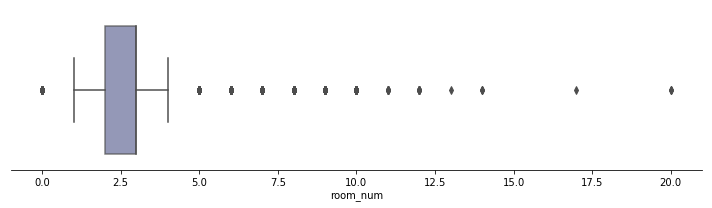

In [62]:
f, axes = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.despine(left=True)

(df
 .loc[:,'room_num']
 .dropna()
 .pipe(sns.boxplot, color=clr['pr'], boxprops=dict(alpha=.7)))

plt.setp(axes, yticks=[])
plt.tight_layout()

In [63]:
df[df.floor == '24ª']

,house_id,ad_description,price,bath_num,condition,construct_date,energetic_certif,floor,ground_size,heating,house_type,m2_real,m2_useful,orientation,room_num,air_conditioner,balcony,built_in_wardrobe,chimney,garage,garden,lift,reduced_mobility,storage_room,swimming_pool,terrace,loc_zone,loc_district,loc_city,loc_neigh,pop_total,pop_0-19,pop_20-64,pop_>=65,pop_foreign,rent,indoor,floor_count,m2_relation
14312,29570055,"Torres Etxezuri. Piso exterior , buena zona ,e...",600000,3,buen estado,NaN,en trámite,24ª,NaN,NaN,Piso,140,NaN,NaN,3,False,False,False,False,NaN,False,1.0,False,False,False,False,Gran Bilbao (BIZ),Indautxu (Bilb),Bilbao,Sabino Arana-Jesuitas (Bilb),345821,16,60,24,11.3,20526,False,1.0,NaN


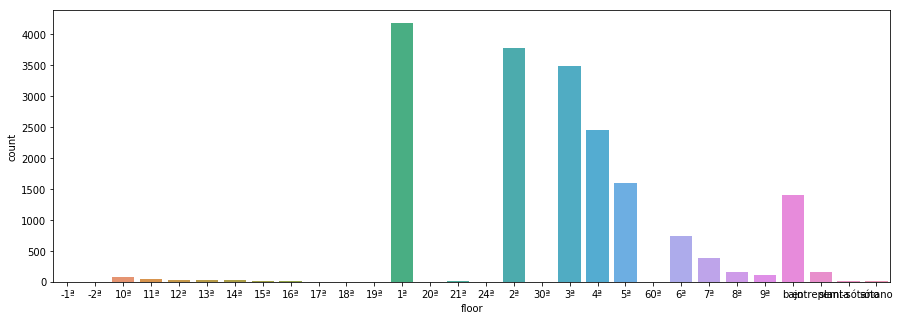

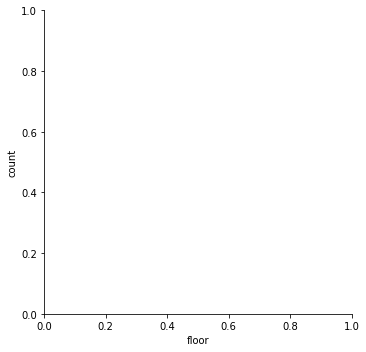

In [64]:
f, axes = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

(df
 .pipe((sns.catplot, 'data'), ax=axes, x='floor', kind="count"))

# Resolver datos incompletos

Empezamos analizando como estan repartidos nuestros *missing values*:

In [65]:


for col in df.columns:
    na_count = sum(pd.isna(df[col]))
    na_perc = round((na_count*100)/len(df),1)
    if(na_count > 0 and na_perc < 50):
        print(f"- {b}{col}{n}: {na_perc}%")
    elif(na_count > 0 and na_perc >= 50):
        print(f"- {b}{col}{n}: {o}{na_perc}%{n}")

- ad_description: 3.2%
- condition: 8.6%
- construct_date: 69.0%
- energetic_certif: 23.9%
- floor: 19.6%
- ground_size: 92.0%
- heating: 62.1%
- m2_useful: 39.1%
- orientation: 57.0%
- garage: 68.2%
- lift: 18.8%
- loc_district: 42.4%
- loc_neigh: 73.5%
- indoor: 9.5%
- floor_count: 9.5%
- m2_relation: 39.1%


Vemos que hay muchas variables con *missing values*, algunas incluso con más del 50% de sus valores. Trataremos todas, excepto la descripción de los anuncios, ya que debido a que solo la usaremos como ayuda en la fase exploratoria, se dejará tal cual.

In [66]:
pandas_profiling.ProfileReport(df)

TypeError: Categorical cannot perform the operation mean

In [ ]:
#(msno.nullity_sort(df, sort="ascending").pipe(msno.bar, color=(0.1,0.3,0.3)));

In [ ]:
(df.query('price > 3000000')
 .style.set_properties(subset=['ad_description'], **{'min-width': '1000px'})
);   

In [ ]:
(df
 .drop(columns=['house_id'])
 .describe(percentiles=[])
 .loc[['min','max'],:]
)

##  Duplicidades

In [92]:
n_records = len(df)
def duplicados_por_columna(df):
    for column in df:
        count_value = df[column].value_counts()
        common = count_value.iloc[0]
        rare = count_value.iloc[-1]
        if ((common / (1.0 * n_records)) > 0.7):
            print("Column:{} ## Common: {}% <> Rare: {}% ## Type: {}".format( df[column].name, 
                                       round(common / (n_records) * 100, 2), 
                                       round(rare / (n_records) * 100, 2),
                                       df[column].dtype
        ))

duplicados_por_columna(df)

Column:condition ## Common: 74.35% <> Rare: 3.64% ## Type: category
Column:house_type ## Common: 78.68% <> Rare: 0.0% ## Type: category
Column:air_conditioner ## Common: 98.14% <> Rare: 1.86% ## Type: bool
Column:balcony ## Common: 78.98% <> Rare: 21.02% ## Type: bool
Column:chimney ## Common: 99.39% <> Rare: 0.61% ## Type: bool
Column:garden ## Common: 81.83% <> Rare: 18.17% ## Type: bool
Column:reduced_mobility ## Common: 89.06% <> Rare: 10.94% ## Type: bool
Column:swimming_pool ## Common: 95.58% <> Rare: 4.42% ## Type: bool
Column:indoor ## Common: 87.92% <> Rare: 2.63% ## Type: category
Column:floor_count ## Common: 82.19% <> Rare: 0.08% ## Type: float64


Parece que tenemos columnas con gran numero de duplicidades. Realmente no sera muy interesante esa variable para futuros modelos. Todo lo que supere de 70% lo descartaria.

## Valores inexistentes

In [93]:
n_records = len(df)
def null_value(df):
    for column in df:
        if len(df[df[column].isnull()]) / (1.0*n_records) > 0.03:
            print("Column:{} ## Per: {}% ## Type: {}".format(
                                    df[column].name, 
                                    round((len(df[df[column].isnull()]) / (n_records)) * 100, 2), 
                                    df[column].dtype
        ))

null_value(df)

Column:ad_description ## Per: 3.16% ## Type: object
Column:condition ## Per: 8.57% ## Type: category
Column:construct_date ## Per: 69.04% ## Type: float64
Column:energetic_certif ## Per: 23.91% ## Type: category
Column:floor ## Per: 19.62% ## Type: category
Column:ground_size ## Per: 91.95% ## Type: float64
Column:heating ## Per: 62.09% ## Type: category
Column:m2_useful ## Per: 39.07% ## Type: float64
Column:orientation ## Per: 57.0% ## Type: category
Column:garage ## Per: 68.21% ## Type: float64
Column:lift ## Per: 18.81% ## Type: category
Column:loc_district ## Per: 42.4% ## Type: object
Column:loc_neigh ## Per: 73.49% ## Type: object
Column:indoor ## Per: 9.46% ## Type: category
Column:floor_count ## Per: 9.46% ## Type: float64
Column:m2_relation ## Per: 39.07% ## Type: float64


Se tiene que mirar como rellenamos estos datos...